# Conditional GAN

Used to generate new training data for the ransomware families to overcome the skewed distribution of training data towards the benign samples

In [192]:
# Packages
from tensorflow import keras
from tensorflow.keras import layers
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

import matplotlib.pyplot as plt 
import tensorflow as tf
import numpy as np
import os

**Change parameters**

-----

In [193]:
# Batch size
batch_size = 64

# Color mode
ch = 'grayscale'

# Image size
iw, ih = 28,28
im_size = (iw,ih)

# Latent dim size
latent_dim = 128

# Number of Epochs
epoch_t = 20

# Training - Validiation split 
val_size = 0.3

# Computation environment: Kaggle (0) or Local (1)
cenv = 1

# If weights are used: Weight factor
wf = 0.5

-----------

Automatic notebook preparation

In [194]:
if(ch == 'rgb'):
    chnum = 3
elif(ch == 'grayscale'):
    chnum = 1

In [195]:
if cenv == 1:
    file_exists = []
    vnum = 1
    dir = "C:/Users/Max/Documents/GitHub/conditional_gan"
    for files in os.listdir(dir):
        if "cgan" in files:
            try:
                vnum = max(vnum, int(files[-3:]))
            except: 
                continue
            new_vnum = vnum + 1
            file_exists.append(True)
        else: 
            file_exists.append(False)
    # If this is the first notebook you want to save, a new folder will be created with version #001
    if sum(file_exists) == 0:
        new_vnum = 1
        print("No matches found")

    else: 
        print(f"{sum(file_exists)} matches(es) found")
        print("--------------")

    # Print new folder name
    print(f"New folder name: cgan-local-v{new_vnum:03}")
    print("--------------")
    
    # Create new folder with the name of the notebook and the version number
    new_dir = f"/Users/Max/Documents/GitHub/conditional_gan/cgan-local-v{new_vnum:03}"
    os.makedirs(new_dir)

1 matches(es) found
--------------
New folder name: cgan-local-v002
--------------


**Data preprocessing**

In [196]:
if cenv == 0:
    path_root = "/kaggle/input/gan-data"
if cenv == 1:
    path_root = "C:/Users/Max/Documents/image_data/data_wo_benign"

In [197]:
datagen = ImageDataGenerator(
    rescale = 1/255)

In [198]:
prelim_dataset = datagen.flow_from_directory(
    directory = path_root,
    color_mode = ch,
    target_size = im_size,
    interpolation = 'bicubic',
    batch_size = 40000,
    shuffle=False
)
imgs, labels = next(prelim_dataset)

Found 12536 images belonging to 10 classes.


In [199]:
num_samples = prelim_dataset.samples
num_classes = max(prelim_dataset.labels) + 1

In [200]:
prelim_dataset.class_indices

{'BetterSurf': 0,
 'Eksor.A': 1,
 'Obfuscator.AFQ': 2,
 'Occamy.C': 3,
 'OnLineGames.CTB': 4,
 'Reveton.A': 5,
 'Sfone': 6,
 'VB.IL': 7,
 'Zbot': 8,
 'Zbot!CI': 9}

Create tf.data.Dataset

In [201]:
dataset = tf.data.Dataset.from_tensor_slices((imgs, labels))
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size)

Calculate number of input channel for Gen and Disc

In [202]:
generator_in_channels = latent_dim + num_classes
discriminator_in_channels = chnum + num_classes
print(generator_in_channels, discriminator_in_channels)

138 11


# Creating discriminator and generator

In [203]:
# Create the discriminator.
discriminator = keras.Sequential(
    [
        keras.layers.InputLayer((iw, ih, discriminator_in_channels)),
        layers.Conv2D(64, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.GlobalMaxPooling2D(),
        layers.Dense(1),
    ],
    name="discriminator",
)


In [205]:
# Create the generator.
generator = keras.Sequential(
    [
        keras.layers.InputLayer((generator_in_channels,)),
        # We want to generate 128 + num_classes coefficients to reshape into a
        # 7x7x(128 + num_classes) map.
        layers.Dense(7 * 7 * generator_in_channels),
        layers.LeakyReLU(alpha=0.2),
        layers.Reshape((7, 7, generator_in_channels)),
        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(1, (7, 7), padding="same", activation="sigmoid"),
    ],
    name="generator",
)

In [206]:
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_31 (Conv2D)           (None, 14, 14, 64)        6400      
_________________________________________________________________
leaky_re_lu_96 (LeakyReLU)   (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 7, 7, 128)         73856     
_________________________________________________________________
leaky_re_lu_97 (LeakyReLU)   (None, 7, 7, 128)         0         
_________________________________________________________________
global_max_pooling2d_4 (Glob (None, 128)               0         
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 129       
Total params: 80,385
Trainable params: 80,385
Non-trainable params: 0
_________________________________________________

In [207]:
generator.summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_29 (Dense)             (None, 6762)              939918    
_________________________________________________________________
leaky_re_lu_101 (LeakyReLU)  (None, 6762)              0         
_________________________________________________________________
reshape_24 (Reshape)         (None, 7, 7, 138)         0         
_________________________________________________________________
conv2d_transpose_67 (Conv2DT (None, 14, 14, 128)       282752    
_________________________________________________________________
leaky_re_lu_102 (LeakyReLU)  (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_transpose_68 (Conv2DT (None, 28, 28, 128)       262272    
_________________________________________________________________
leaky_re_lu_103 (LeakyReLU)  (None, 28, 28, 128)       0 

**Create Conditional GAN**

In [208]:
class ConditionalGAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(ConditionalGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.gen_loss_tracker = keras.metrics.Mean(name="generator_loss")
        self.disc_loss_tracker = keras.metrics.Mean(name="discriminator_loss")

    @property
    def metrics(self):
        return [self.gen_loss_tracker, self.disc_loss_tracker]

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(ConditionalGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    def train_step(self, data):
        # Unpack the data.
        real_images, one_hot_labels = data

        # Add dummy dimensions to the labels so that they can be concatenated with
        # the images. This is for the discriminator.
        image_one_hot_labels = one_hot_labels[:, :, None, None]
        image_one_hot_labels = tf.repeat(
            image_one_hot_labels, repeats=[ih * iw]
        )
        image_one_hot_labels = tf.reshape(
            image_one_hot_labels, (-1, iw, ih, num_classes)
        )

        # Sample random points in the latent space and concatenate the labels.
        # This is for the generator.
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        random_vector_labels = tf.concat(
            [random_latent_vectors, one_hot_labels], axis=1
        )

        # Decode the noise (guided by labels) to fake images.
        generated_images = self.generator(random_vector_labels)

        # Combine them with real images. Note that we are concatenating the labels
        # with these images here.
        fake_image_and_labels = tf.concat([generated_images, image_one_hot_labels], -1)
        real_image_and_labels = tf.concat([real_images, image_one_hot_labels], -1)
        combined_images = tf.concat(
            [fake_image_and_labels, real_image_and_labels], axis=0
        )

        # Assemble labels discriminating real from fake images.
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )

        # Train the discriminator.
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space.
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        random_vector_labels = tf.concat(
            [random_latent_vectors, one_hot_labels], axis=1
        )

        # Assemble labels that say "all real images".
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            fake_images = self.generator(random_vector_labels)
            fake_image_and_labels = tf.concat([fake_images, image_one_hot_labels], -1)
            predictions = self.discriminator(fake_image_and_labels)
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Monitor loss.
        self.gen_loss_tracker.update_state(g_loss)
        self.disc_loss_tracker.update_state(d_loss)
        return {
            "g_loss": self.gen_loss_tracker.result(),
            "d_loss": self.disc_loss_tracker.result(),
        }

# Training C-GAN

In [209]:
cond_gan = ConditionalGAN(
    discriminator=discriminator, generator=generator, latent_dim=latent_dim
)
cond_gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0003),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0003),
    loss_fn=keras.losses.BinaryCrossentropy(from_logits=True),
)

cond_gan.fit(dataset, epochs=epoch_t)


Epoch 1/20
196/196 [==============================] - 6s 27ms/step - g_loss: 0.8593 - d_loss: 0.6556
Epoch 2/20
196/196 [==============================] - 5s 27ms/step - g_loss: 1.0493 - d_loss: 0.5956
Epoch 3/20
196/196 [==============================] - 5s 27ms/step - g_loss: 0.8534 - d_loss: 0.6594
Epoch 4/20
196/196 [==============================] - 5s 26ms/step - g_loss: 1.2847 - d_loss: 0.5256
Epoch 5/20
196/196 [==============================] - 5s 26ms/step - g_loss: 0.7747 - d_loss: 0.6778
Epoch 6/20
196/196 [==============================] - 5s 26ms/step - g_loss: 0.8108 - d_loss: 0.6288
Epoch 7/20
196/196 [==============================] - 5s 27ms/step - g_loss: 0.8247 - d_loss: 0.6291
Epoch 8/20
196/196 [==============================] - 5s 27ms/step - g_loss: 0.8729 - d_loss: 0.6059
Epoch 9/20
196/196 [==============================] - 6s 28ms/step - g_loss: 0.9598 - d_loss: 0.6178
Epoch 10/20
196/196 [==============================] - 6s 30ms/step - g_loss: 0.8384 - d_lo

# Interpolating between classes with the trained GEN

In [210]:
# We first extract the trained generator from our Conditiona GAN.
trained_gen = cond_gan.generator

# Choose the number of intermediate images that would be generated in
# between the interpolation + 2 (start and last images).
num_interpolation = 9  # @param {type:"integer"}

# Sample noise for the interpolation.
interpolation_noise = tf.random.normal(shape=(1, latent_dim))
interpolation_noise = tf.repeat(interpolation_noise, repeats=num_interpolation)
interpolation_noise = tf.reshape(interpolation_noise, (num_interpolation, latent_dim))


def interpolate_class(first_number, second_number):
    # Convert the start and end labels to one-hot encoded vectors.
    first_label = keras.utils.to_categorical([first_number], num_classes)
    second_label = keras.utils.to_categorical([second_number], num_classes)
    first_label = tf.cast(first_label, tf.float32)
    second_label = tf.cast(second_label, tf.float32)

    # Calculate the interpolation vector between the two labels.
    percent_second_label = tf.linspace(0, 1, num_interpolation)[:, None]
    percent_second_label = tf.cast(percent_second_label, tf.float32)
    interpolation_labels = (
        first_label * (1 - percent_second_label) + second_label * percent_second_label
    )

    # Combine the noise and the labels and run inference with the generator.
    noise_and_labels = tf.concat([interpolation_noise, interpolation_labels], 1)
    fake = trained_gen.predict(noise_and_labels)
    return fake


start_class = 1  # @param {type:"slider", min:0, max:9, step:1}
end_class = 6  # @param {type:"slider", min:0, max:9, step:1}

fake_images = interpolate_class(start_class, end_class)

In [211]:
fake_images *= 255

In [212]:
converted_images = fake_images.astype(np.uint8)

In [213]:
converted_images = tf.image.resize(converted_images, (64, 64)).numpy().astype(np.uint8)

In [214]:
converted_images.shape

(9, 64, 64, 1)

In [215]:
plt.figure(converted_images)
plt.show()

TypeError: only size-1 arrays can be converted to Python scalars

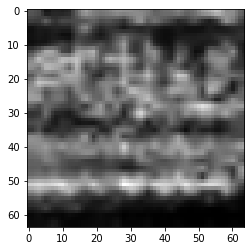

In [221]:
for x in range(num_interpolation): 
    plt.imshow((converted_images[2]), cmap='gray')